# Extraction des données

## 1- Importation des modules de base

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

from datetime import timedelta
from PIL.Image import *
import time
import seaborn as sns
import matplotlib.pyplot as plt
import csv

## 2- Extraction de jeu de données

In [42]:
def initialize(dataset_size):
    data = pd.read_csv("./ressources/images/batiments.csv",delimiter = ';', header=None)
    data.columns = ["ID","Label"]
    #on melange le dataframe
    data = data.sample(frac=1)
    #delete rows for learning curves
    data=data.drop(data.index[dataset_size:])
    print("taille init: ",len(data))
    return data
data = initialize(2000)
data.info()

taille init:  2000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1152 to 1041
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      2000 non-null   int64 
 1   Label   2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 46.9+ KB


# Opération sur les données

## 1- Répartition des données

<AxesSubplot: xlabel='Label', ylabel='count'>

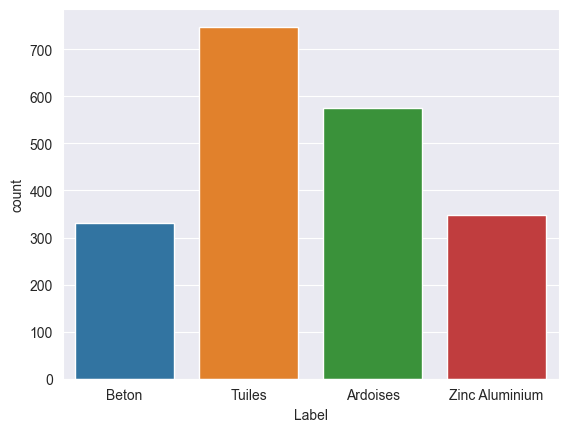

In [43]:
sns.countplot(x='Label',data=data,label="Nombre")

## 2- Ajout de colonnes au dataset avec la moyenne RGB du chunk central de X*X pixels

###     A. Choix de la taille du chunk central qui sera analysé

In [44]:
CHUNK_SIZE = 32

In [45]:
def read_pixel_chunk(chunk_size = 16,dataset=data):
    r = []
    v = []
    b = []
    for image in dataset["ID"]:
        im = open("./ressources/images/"+str(image)+".jpg")
        (rouge, vert, bleu) = (0,0,0)
        #On fait la moyenne pour chaque pixel du bloc central de 16x16
        for x in range(chunk_size):
            for y in range(chunk_size):
                (rouge, vert, bleu) = (x + y for x, y in zip((rouge, vert, bleu), im.getpixel(((256-chunk_size)//2+x, (256-chunk_size)//2+y))))
        im.close()
        (rouge, vert, bleu) = (round(rouge/chunk_size,5), round(vert/chunk_size,5), round(bleu/chunk_size,5))
        r.append(rouge)
        v.append(vert)
        b.append(bleu)
    return r,v,b

On analyse la moyenne RGB du bloc central de 16 par 16 pixels.
**Il faut maintenant ajouter ces colonnes au dataset :**

In [46]:
results = read_pixel_chunk(CHUNK_SIZE)
data["rouge"] = results[0]
data["vert"] = results[1]
data["bleu"] = results[2]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1152 to 1041
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      2000 non-null   int64  
 1   Label   2000 non-null   object 
 2   rouge   2000 non-null   float64
 3   vert    2000 non-null   float64
 4   bleu    2000 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 93.8+ KB


## 3- Optimisation et Pre-Processing

###     A. Normalisation des données


In [47]:
def scaling():
    scaler = MinMaxScaler()
    data[['rouge','vert','bleu']] = scaler.fit_transform(data[['rouge','vert','bleu']])
#scaling()
#data

###     B. Standardization

Les variables R,G et B ont une moyenne de 0  et une variance de 1 --> Permet d'éliminer les résultats aberrants

In [48]:
def standardize():
    std_scaler = StandardScaler()
    data[['rouge','vert','bleu']] = std_scaler.fit_transform(data[['rouge','vert','bleu']])
#standardize()
#data

## 4- Création des dataset

On va sélectionner aléatoirement 75% d'individus de chaque matériau pour créer le jeu d'apprentissage et les 25% restants serviront à tester notre modèle.

In [49]:
def create_datasets(dataset):
    data_tuiles = dataset[dataset['Label']== 'Tuiles' ]
    data_zinc = dataset[dataset['Label']== 'Zinc Aluminium' ]
    data_ardoises = dataset[dataset['Label']== 'Ardoises' ]
    data_beton = dataset[dataset['Label']== 'Beton' ]

    learning_df = pd.concat([data_tuiles.sample(frac=0.75),data_zinc.sample(frac=0.75),data_ardoises.sample(frac=0.75),data_beton.sample(frac=0.75)] , ignore_index=True)
    test_df = dataset.drop(learning_df.index)
    return learning_df,test_df

In [50]:
learning_df, test_df =create_datasets(data)
learning_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      1500 non-null   int64  
 1   Label   1500 non-null   object 
 2   rouge   1500 non-null   float64
 3   vert    1500 non-null   float64
 4   bleu    1500 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 58.7+ KB


# Algorithme

## 1- Analyse des composantes RGB de chaque matériau de learning dataset

On fait la moyenne RGB de chaque type de matériau pour avoir une estimation des composantes de ce dernier.

In [51]:
def avg_materiau():
    learning_tuiles = learning_df[learning_df['Label']== 'Tuiles' ]
    learning_zinc = learning_df[learning_df['Label']== 'Zinc Aluminium' ]
    learning_ardoises = learning_df[learning_df['Label']== 'Ardoises' ]
    learning_beton = learning_df[learning_df['Label']== 'Beton' ]

    avg_tuile = [learning_tuiles["rouge"].mean(),learning_tuiles["vert"].mean(),learning_tuiles["bleu"].mean()]
    avg_zinc = [learning_zinc["rouge"].mean(),learning_zinc["vert"].mean(),learning_zinc["bleu"].mean()]
    avg_ardoise = [learning_ardoises["rouge"].mean(),learning_ardoises["vert"].mean(),learning_ardoises["bleu"].mean()]
    avg_beton = [learning_beton["rouge"].mean(),learning_beton["vert"].mean(),learning_beton["bleu"].mean()]
    return avg_tuile,avg_zinc,avg_ardoise,avg_beton

## 2- Prediction du type de toit d'un bâtiment

In [52]:
avg = avg_materiau()
classes = ["Tuiles","Zinc Aluminium", "Ardoises","Beton"]

In [53]:
def euclidean_distance(ind_1, ind_2):
    ''' Calcule la distance euclidienne entre 2 individus'''
    distance = [(a - b)**2 for a, b in zip(ind_1, ind_2)]
    distance = np.sqrt(sum(distance))
    return distance

In [54]:
def Type_de_toit_predit(image_a_predire,chunk_size):
    image = open("./ressources/images/"+str(image_a_predire)+".jpg")
    [rouge, vert, bleu] = [0, 0, 0]
    # On fait la moyenne pour chaque pixel du bloc central de 16x16
    for x in range(chunk_size):
        for y in range(chunk_size):
            [rouge, vert, bleu] = (x + y for x, y in zip((rouge, vert, bleu), image.getpixel(((256-chunk_size)//2+x, (256-chunk_size)//2+y))))
    image.close()
    [rouge, vert, bleu] = [round(rouge/chunk_size,5), round(vert/chunk_size,5), round(bleu/chunk_size,5)]

    distances = [euclidean_distance([rouge, vert, bleu],i) for i in avg]
    return classes[np.argmin(distances)]

Prédiction du type de toît de l'image à prédire de manière statistique.

## 3- Score

In [55]:
def score(avg,chunk_size=16):
    im_prediction = []
    im_true = []
    conf_matrix = [[0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0],
                  [0,0,0,0]]
    for image in test_df.index:
        # Image test = (ID,type,lien)
        identified_as = Type_de_toit_predit(test_df["ID"][image],chunk_size)
        # On modifie la matrice de confusion en fonction du resultat
        # On classe de cette maniere : beton,tuiles,ardoises,zinc
        x,y = classes.index(test_df["Label"][image]),classes.index(identified_as)
        im_prediction.append(y)
        im_true.append(x)

        conf_matrix[x][y] += 1

    #sns.heatmap(conf_matrix, square=True, annot=True, fmt='d')
    #plt.show()
    print(classification_report(im_true, im_prediction, target_names=classes))
    return round((conf_matrix[0][0] + conf_matrix[1][1] + conf_matrix[2][2] + conf_matrix[3][3]) / len(test_df) * 100 , 4)

In [56]:
#sc = score(avg,CHUNK_SIZE)
#print(sc,"%")

In [57]:
def run(CHUNK_SIZE,DATSET_SIZE):
    data = initialize(DATSET_SIZE)
    print("taille dataset : ",len(data))
    results = read_pixel_chunk(CHUNK_SIZE,data)
    #print("nb pixels : ",len(results[0]))
    data["rouge"] = results[0]
    data["vert"] = results[1]
    data["bleu"] = results[2]

    learning_df, test_df =create_datasets(data)
    print("\nlearning size and test : ",len(learning_df),len(test_df))
    avg = avg_materiau()
    sc = score(avg,CHUNK_SIZE)
    #print(sc,"%")
    return sc

In [58]:
run(32,2000)

taille init:  2000
taille dataset :  2000

learning size and test :  1500 500
                precision    recall  f1-score   support

        Tuiles       0.87      0.79      0.83       296
Zinc Aluminium       0.45      0.41      0.43        37
      Ardoises       0.70      0.73      0.71       102
         Beton       0.29      0.42      0.34        65

      accuracy                           0.70       500
     macro avg       0.58      0.59      0.58       500
  weighted avg       0.73      0.70      0.71       500



70.2

In [59]:
def curves(CHUNK_SIZE):
    accuracy = []
    dataset_sizes = []
    for i in range(100,2100,100):
        print(i)
        run_ = run(CHUNK_SIZE,i)
        accuracy.append(run_)
        dataset_sizes.append(i)
    plt.plot(dataset_sizes,accuracy)
    plt.show()

In [60]:
#curves(32)